In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
# Enable inline plotting in Jupyter Notebook
%matplotlib inline

In [8]:
data = pd.read_csv("x_train_no_outlier.csv")
data = data[["train", "gare", "date", "arret", "p2q0", "p3q0", "p4q0", "p0q2", "p0q3", "p0q4"]]

In [7]:
data.head()

,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
0,VBXNMF,KYF,2023-04-03,8,0.0,0.0,1.0,-3.0,-1.0,-2.0
1,VBXNMF,JLR,2023-04-03,9,0.0,0.0,0.0,1.0,0.0,1.0
2,VBXNMF,EOH,2023-04-03,10,-1.0,0.0,0.0,-1.0,0.0,0.0
3,VBXNMF,VXY,2023-04-03,11,-1.0,-1.0,0.0,2.0,-2.0,0.0
4,VBXNMF,OCB,2023-04-03,12,-1.0,-1.0,-1.0,-1.0,3.0,2.0


### 1. Train feature

*First, we show if the train feature is useful*

In [12]:
# We first drop all same train in the same date
df = data[["train", "date"]].drop_duplicates()

# Count the occurrences of each train in the 'train' column
# If your column is named 'trains', replace 'train' with 'trains'
train_counts = df['train'].value_counts()

# Filter to get only the train values that occur 2 or more times
trains_multiple = train_counts[train_counts > 1]

# Print out the train occurrences that are greater than 1 (i.e. 2 or more)
print("Trains with 2 or more occurrences across the whole period:")
print(trains_multiple)

Trains with 2 or more occurrences across the whole period:
train
PBYUMJ    2
Name: count, dtype: int64


Only one train appears twice in 2 different days, it is either an error or for any specific reason, but anyway we can consider that the train variable is not really relevant if we do not treat them as a time series

In [26]:
# Mean occurence of arret per train
df_gares = data.groupby(["train"])["arret"].count()
mean_gare = df_gares.mean()
print(f"Mean gares per train (in the dataset) {mean_gare}")

Mean gares per train (in the dataset) 17.74689006686023


### 2. Gare

In [21]:
nb_gare_unique = len(data["gare"].drop_duplicates())
print(f"number of unique gares: {nb_gare_unique}")

number of unique gares: 84


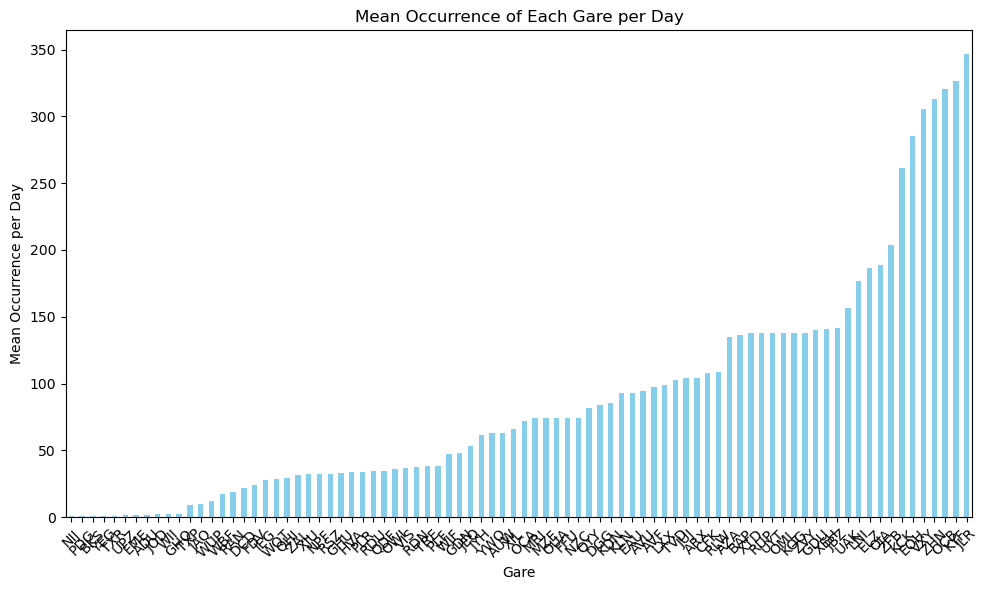

In [29]:
nb_days = len(data["date"].drop_duplicates())

# Group by 'gare' and by each day (extracting the date part) to count daily occurrences
daily_counts = data.groupby(['gare', data['date'].dt.date]).size().reset_index(name='count')

# Compute the mean occurrence per day for each 'gare'
mean_occurrence = daily_counts.groupby('gare')['count'].mean()

# Plot the results as a bar chart
plt.figure(figsize=(10, 6))
mean_occurrence.sort_values().plot(kind='bar', color='skyblue')
plt.xlabel('Gare')
plt.ylabel('Mean Occurrence per Day')
plt.title('Mean Occurrence of Each Gare per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
mean_daily = mean_occurrence.mean()
print("Mean Daily Occurrence:")
print(mean_daily)

Mean Daily Occurrence:
87.99377513179763


In [37]:
# Select the top 20 'gare' with the highest mean occurrences
top20 = mean_occurrence.sort_values(ascending=False).head(20)

# Print the top 20 mean occurrences for inspection
print("Top 20 Gare by Mean Daily Occurrence:")
print(top20)

Top 20 Gare by Mean Daily Occurrence:
gare
JLR    347.000000
KYF    326.241758
OCB    320.747253
ZHN    312.978022
VXY    305.461538
EOH    285.571429
KCK    261.097561
ZFB    203.505495
OJA    188.461538
ELZ    186.505495
LNI    176.714286
UAK    156.791209
JBZ    141.890110
XEH    140.472527
GDU    139.868132
ZVY    138.175824
KOG    138.087912
OML    137.945055
UYT    137.879121
RUP    137.637363
Name: count, dtype: float64


In [33]:
# Select the bottom 20 'gare' with the lowest mean occurrences
bottom20 = mean_occurrence.sort_values(ascending=True).head(20)

# Print the bottom 20 mean occurrences for inspection
print("Bottom 20 Gare by Mean Daily Occurrence:")
print(bottom20)

Bottom 20 Gare by Mean Daily Occurrence:
gare
NIJ     1.000000
PDG     1.083333
BKS     1.139535
YEG     1.190476
TXR     1.200000
UPZ     1.241379
EME     1.315789
ADU     1.327273
JOD     2.155556
WII     2.238636
GHQ     2.633333
TXP     9.351648
JAQ     9.769231
WUP    12.266667
WBF    16.944444
RAN    18.844444
DCD    21.755556
FDV    24.098901
IEG    27.582418
WQT    28.696629
Name: count, dtype: float64


### 3. Gare/arret feature

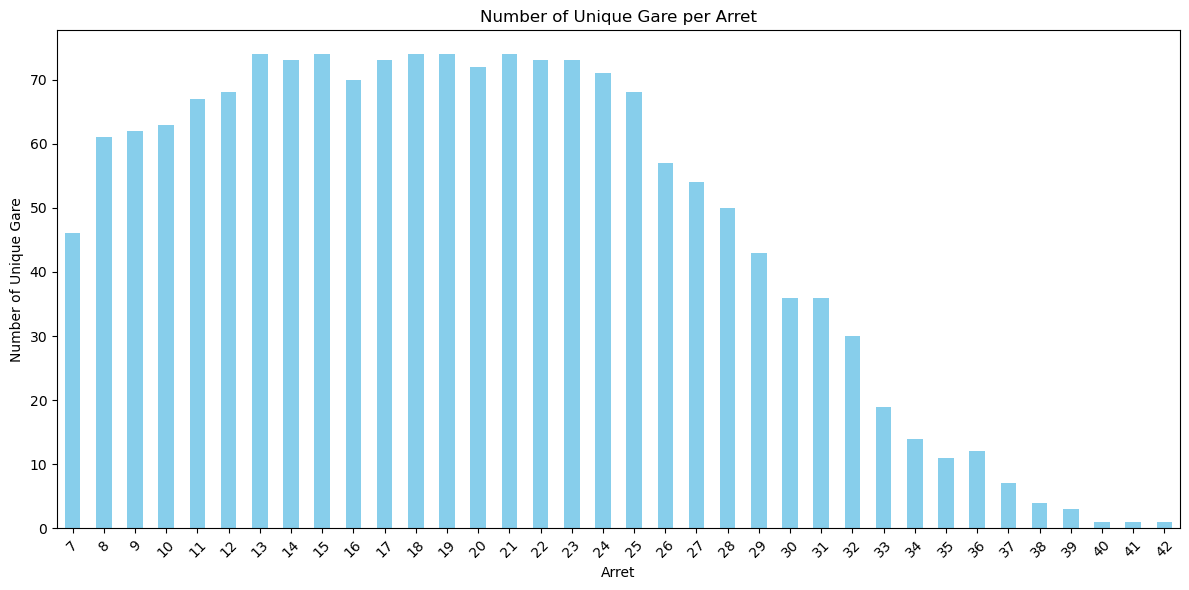

In [47]:
# Group by "arret" and count the unique "gare" values for each arret.
gare_per_arret = data.groupby("arret")["gare"].nunique()

# Plot the results as a bar chart
plt.figure(figsize=(12, 6))
gare_per_arret.sort_index().plot(kind='bar', color='skyblue')
plt.xlabel("Arret")
plt.ylabel("Number of Unique Gare")
plt.title("Number of Unique Gare per Arret")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Extremely skewed distribution, as we could imagined**

### 4. P feature

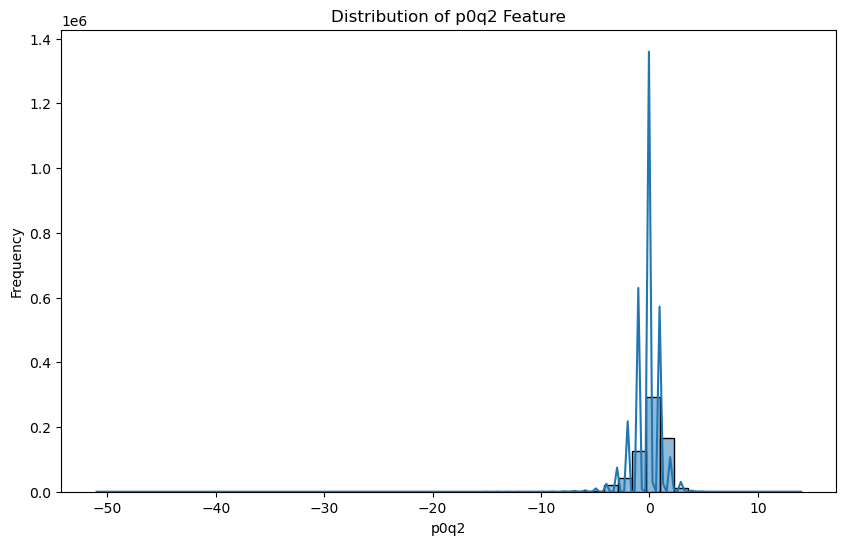

In [36]:
# Plot the distribution of the p0q2 feature
plt.figure(figsize=(10, 6))
sns.histplot(data['p2q0'], bins=50, kde=True)
plt.title("Distribution of p2q0 Feature")
plt.xlabel("p3q0")
plt.ylabel("Frequency")
plt.show()

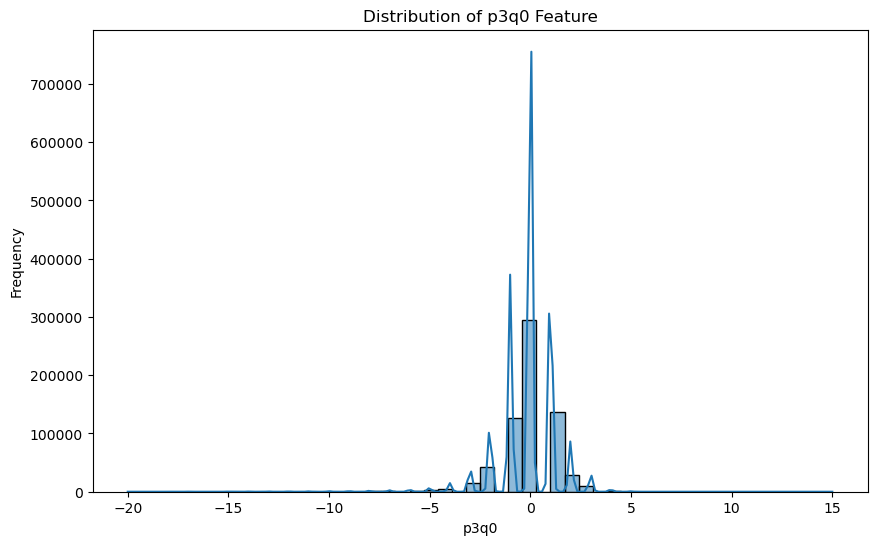

In [40]:
# Plot the distribution of the p0q3 feature
plt.figure(figsize=(10, 6))
sns.histplot(data['p3q0'], bins=50, kde=True)
plt.title("Distribution of p3q0 Feature")
plt.xlabel("p3q0")
plt.ylabel("Frequency")
plt.show()

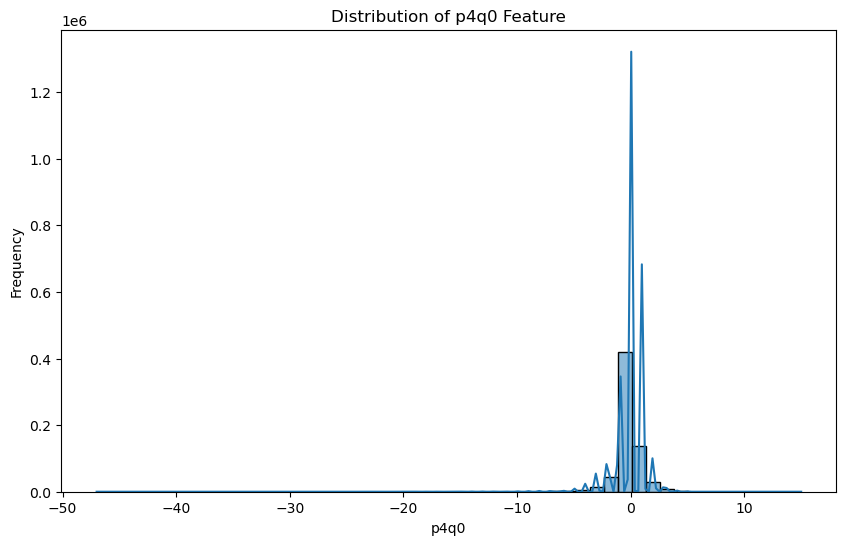

In [44]:
# Plot the distribution of the p0q4 feature
plt.figure(figsize=(10, 6))
sns.histplot(data['p4q0'], bins=50, kde=True)
plt.title("Distribution of p4q0 Feature")
plt.xlabel("p4q0")
plt.ylabel("Frequency")
plt.show()

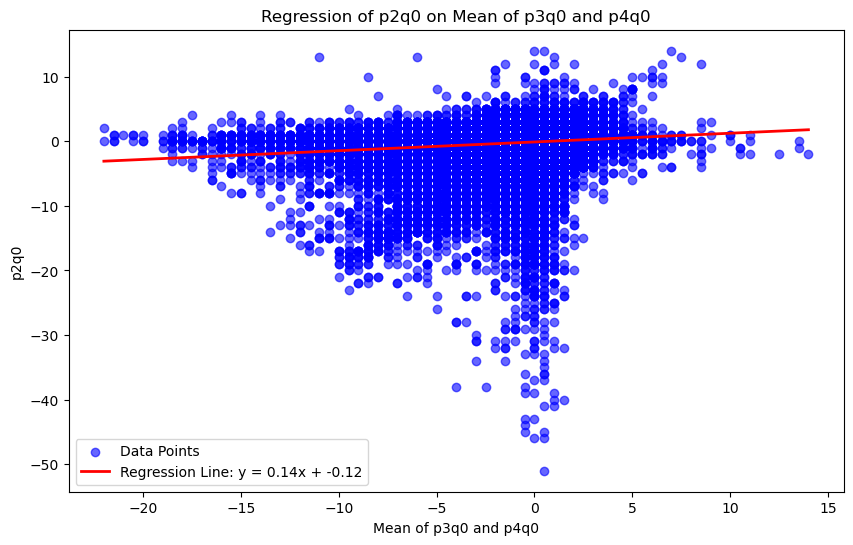

In [21]:
# Compute the mean of p3q0 and p4q0 for each observation
data['mean_p3q0_p4q0'] = (data['p3q0'] + data['p4q0']) / 2

# Prepare the predictor (x) and response (y) variables
x = data['mean_p3q0_p4q0']
y = data['p2q0']

# Perform a simple linear regression using np.polyfit (degree 1)
slope, intercept = np.polyfit(x, y, 1)

# Generate x values for plotting the regression line
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = slope * x_vals + intercept

# Plot the scatter plot and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.6, label='Data Points')
plt.plot(x_vals, y_vals, color='red', linewidth=2, label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('Mean of p3q0 and p4q0')
plt.ylabel('p2q0')
plt.title('Regression of p2q0 on Mean of p3q0 and p4q0')
plt.legend()
plt.show()# Compute the mean of p3q0 and p4q0 for each observation

### 5. Q feature

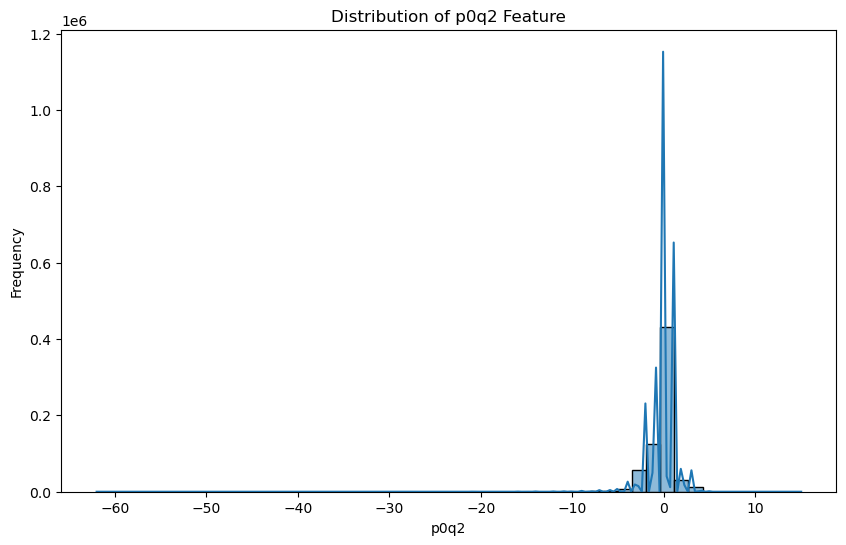

In [30]:
# Plot the distribution of the p0q2 feature
plt.figure(figsize=(10, 6))
sns.histplot(data['p0q2'], bins=50, kde=True)
plt.title("Distribution of p0q2 Feature")
plt.xlabel("p0q2")
plt.ylabel("Frequency")
plt.show()

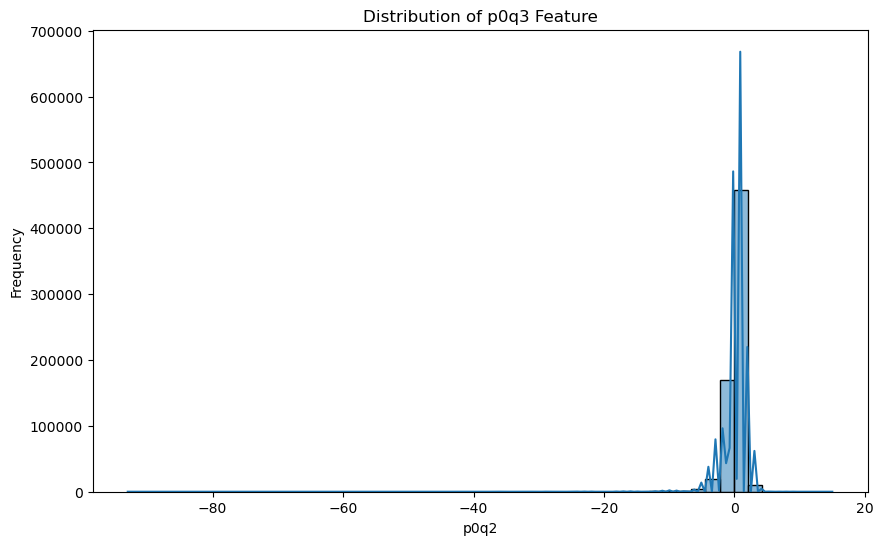

In [31]:
# Plot the distribution of the p0q3 feature
plt.figure(figsize=(10, 6))
sns.histplot(data['p0q3'], bins=50, kde=True)
plt.title("Distribution of p0q3 Feature")
plt.xlabel("p0q2")
plt.ylabel("Frequency")
plt.show()

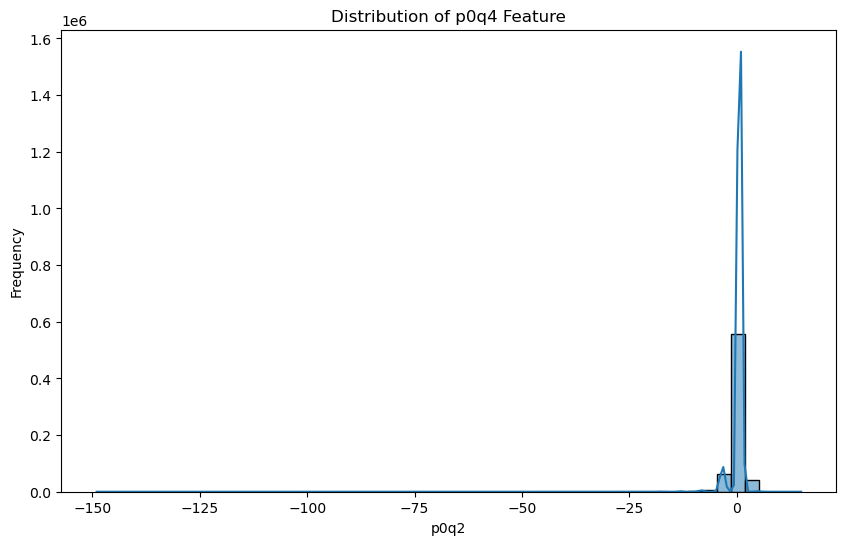

In [34]:
# Plot the distribution of the p0q4 feature
plt.figure(figsize=(10, 6))
sns.histplot(data['p0q4'], bins=50, kde=True)
plt.title("Distribution of p0q4 Feature")
plt.xlabel("p0q2")
plt.ylabel("Frequency")
plt.show()

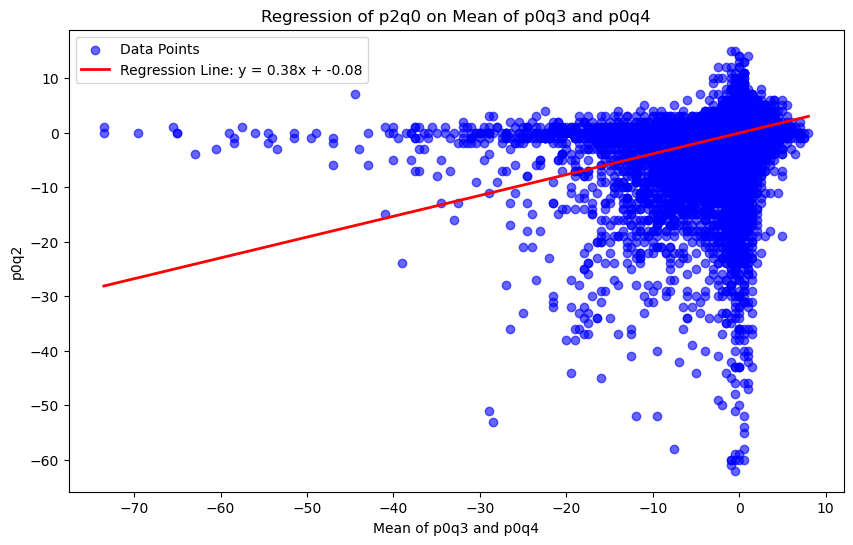

In [62]:
# Compute the mean of p3q0 and p4q0 for each observation
data['mean_p0q3_p0q4'] = (data['p0q3'] + data['p0q4']) / 2

# Prepare the predictor (x) and response (y) variables
x = data['mean_p0q3_p0q4']
y = data['p0q2']

# Perform a simple linear regression using np.polyfit (degree 1)
slope, intercept = np.polyfit(x, y, 1)

# Generate x values for plotting the regression line
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = slope * x_vals + intercept

# Plot the scatter plot and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.6, label='Data Points')
plt.plot(x_vals, y_vals, color='red', linewidth=2, label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('Mean of p0q3 and p0q4')
plt.ylabel('p0q2')
plt.title('Regression of p2q0 on Mean of p0q3 and p0q4')
plt.legend()
plt.show()# Compute the mean of p3q0 and p4q0 for each observation

In [33]:
# Let's try to look at the p and q feature for each train

df_by_train = data.groupby(by=["train"])
df_by_train.head()

,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
0,VBXNMF,KYF,2023-04-03,8,0.0,0.0,1.0,-3.0,-1.0,-2.0
1,VBXNMF,JLR,2023-04-03,9,0.0,0.0,0.0,1.0,0.0,1.0
2,VBXNMF,EOH,2023-04-03,10,-1.0,0.0,0.0,-1.0,0.0,0.0
3,VBXNMF,VXY,2023-04-03,11,-1.0,-1.0,0.0,2.0,-2.0,0.0
4,VBXNMF,OCB,2023-04-03,12,-1.0,-1.0,-1.0,-1.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...
666217,BFNJJK,WJF,2023-11-10,8,0.0,-1.0,-1.0,1.0,1.0,1.0
666218,BFNJJK,JYH,2023-11-10,9,0.0,0.0,-1.0,0.0,-1.0,0.0
666219,BFNJJK,UYT,2023-11-10,10,0.0,0.0,0.0,-7.0,0.0,-1.0
666220,BFNJJK,EAU,2023-11-10,11,0.0,0.0,0.0,0.0,-1.0,-1.0
